<a href="https://colab.research.google.com/github/sridevibonthu/trails/blob/master/please_run_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q "/content/gdrive/My Drive/Assignment5/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Assignment5')
import clr
import cutout

In [0]:

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
      def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img
      return eraser

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, train_mean, train_std, batch_size=32, shuffle=True, val=False):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.eraser = get_random_eraser()
        self.train_mean = train_mean
        self.val = val
        self.train_std = train_std

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        images = []
        for image in [cv2.imread(item["image_path"]) for _, item in items.iterrows()]:
          # normalize mean of 0 and stdev of 1
          image = ((image-self.train_mean)/self.train_std).astype('float32')       

          if not self.val:
            image = self.eraser(image)


          images.append(image)

        images = np.stack(images, axis=0)
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)



In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
from tqdm import tnrange, tqdm_notebook
n = 0
s = np.zeros(3)
sq = np.zeros(3)
y = None
for _, item in tqdm_notebook(train_df.iterrows()):
  x = cv2.imread(item["image_path"]).astype('double')
  s += np.sum(x, axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]
  y = x

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))

print(mu, std, n)


[41.26352222 41.47657651 46.5647948 ] [63.89415993 64.53129496 69.7487991 ] 578880512


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, mu, std, batch_size=32)
valid_gen = PersonDataGenerator(val_df, mu, std, batch_size=64, shuffle=False, val=True)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
from keras.applications import VGG16
backbone = VGG16(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)





58892288/58889256 [==============================] - 2s 0us/step








In [0]:
neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)

In [0]:


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = False

In [0]:

clr1 = clr.CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000., mode='triangular')



callbacks = [clr1]

In [0]:
opt = SGD(lr=0.1, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=24,
    verbose=1,
    callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/24
359/360 [============================>.] - ETA: 0s - loss: 8.6319 - gender_output_loss: 0.7437 - image_quality_output_loss: 1.0682 - age_output_loss: 1.5685 - weight_output_loss: 1.1021 - bag_output_loss: 1.0121 - footwear_output_loss: 1.1022 - pose_output_loss: 1.0067 - emotion_output_loss: 1.0284 - gender_output_acc: 0.5472 - image_quality_output_acc: 0.5308 - age_output_acc: 0.3734 - weight_output_acc: 0.6209 - bag_output_acc: 0.5413 - footwear_output_acc: 0.4615 - pose_output_acc: 0.6029 - emotion_output_acc: 0.7036

360/360 [==============================] - 53s 147ms/step - loss: 8.6293 - gender_output_loss: 0.7436 - image_quality_output_loss: 1.0678 - age_output_loss: 1.5679 - weight_output_loss: 1.1016 - bag_output_loss: 1.0120 - footwear_output_loss: 1.1016 - pose_output_loss: 1.0066 - emotion_output_loss: 1.0282 - gender_output_acc: 0.5470 - image_quality_output_acc: 0.5

In [0]:
history=model.history

In [0]:
#print(history.history.keys())
for x in history.history.keys():
  if x.startswith('val') and x.endswith('acc'):
    print(x, " -- ",  history.history[x][-1])

val_gender_output_acc  --  0.5383064516129032
val_image_quality_output_acc  --  0.5735887096774194
val_age_output_acc  --  0.40524193548387094
val_weight_output_acc  --  0.6355846774193549
val_bag_output_acc  --  0.5574596774193549
val_footwear_output_acc  --  0.4425403225806452
val_pose_output_acc  --  0.6174395161290323
val_emotion_output_acc  --  0.7086693548387096


In [0]:
history=model.history

In [0]:
val_loss=[]
for i in range(24
               ):
  sum=0
  l = ['val_gender_output_loss','val_image_quality_output_loss',  'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss',
 'val_emotion_output_loss']
  for x in l:
    sum += history.history[x][i]
  val_loss.append(sum)
print(val_loss)

[7.739757574373676, 7.724067475526564, 7.871237987472165, 7.872531517859429, 7.869513942349341, 7.877387498655628, 7.87303860533622, 7.874986106349576, 7.869598392517335, 7.868965701710794, 7.868868629778586, 7.870253014949061, 7.869432318595147, 7.871756296004018, 7.872361021657144, 7.873762895984034, 7.873152913585785, 7.875221606223814, 7.872125183382342, 7.872491328947006, 7.871280941271014, 7.869987620461372, 7.870339549356891, 7.8718164553565355]


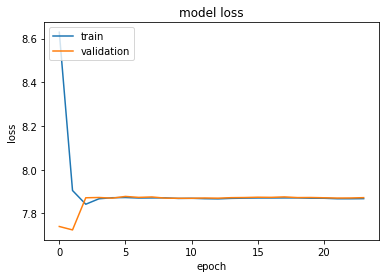

In [0]:
  import matplotlib.pyplot as plt
  plt.plot(history.history['loss'])
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()  #no reduction in validation loss

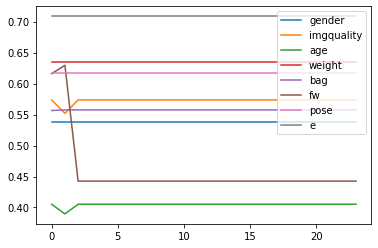

In [0]:
plt.plot(history.history['val_gender_output_acc'])
plt.plot(history.history['val_image_quality_output_acc'])
plt.plot(history.history['val_age_output_acc'])
plt.plot(history.history['val_weight_output_acc'])
plt.plot(history.history['val_bag_output_acc'])
plt.plot(history.history['val_footwear_output_acc'])
plt.plot(history.history['val_pose_output_acc'])
plt.plot(history.history['val_emotion_output_acc'])
plt.legend(['gender', 'imgquality','age','weight', 'bag','fw','pose','e'], loc='upper right')
plt.show()

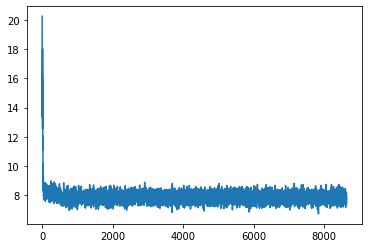

In [0]:
h=clr1.history
plt.plot(h['loss'])
plt.show()

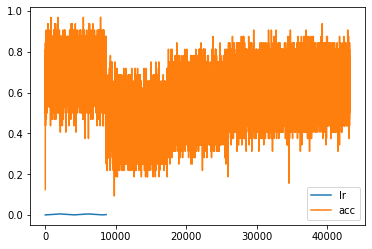

In [0]:
plt.plot(h['lr'])
plt.plot(h['emotion_output_acc']+h['footwear_output_acc']+h['image_quality_output_acc']+h['pose_output_acc']+h['weight_output_acc'])
plt.legend(['lr','acc'])
plt.show()

In [0]:
max(h['lr'])

0.006

In [0]:
min(h['lr'])

0.001